In [1]:
%pip install yfinance


Note: you may need to restart the kernel to use updated packages.


In [150]:
# import importlib
# import get_data
# importlib.reload(get_data)


<module 'get_data' from 'c:\\Users\\CVUONG12\\Downloads\\Final project\\get_data.py'>


## Classification of earning transcript to predict whether it has Positive, Neutral or Negative impact on stock price

### 1. Collecting input data using get_data.py

In [152]:
# Import the functions from get_prices.py
from get_data import get_tickers, get_price, get_earnings_transcripts

tickers = get_tickers() # List of tickers from S&P 500 index
start_date = '2019-01-01'
end_date = '2024-01-01'
file_path = r'C:\Users\CVUONG12\Downloads\ET data\motley-fool-data.pkl' #this file is uploaded to the repo

# Get the daily prices
daily_prices = get_price(tickers, start_date, end_date)
earnings_transcripts = get_earnings_transcripts(file_path, tickers)
# print(earnings_transcripts)


[****                   9%%                      ]  45 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2019-01-01 -> 2024-01-01)


[*********************100%%**********************]  503 of 503 completed

5 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-01 -> 2024-01-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['SW', 'SOLV', 'GEV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1704085200")


                              date      exchange        q ticker  \
2       Oct 23, 2019, 5:00 p.m. ET  NASDAQ: LRCX  2020-Q1   LRCX   
11      Aug 26, 2021, 9:00 a.m. ET     NYSE: SJM  2022-Q1    SJM   
19      Nov 06, 2019, 4:30 p.m. ET  NASDAQ: DXCM  2019-Q3   DXCM   
24       Jul 1, 2021, 8:30 a.m. ET   NASDAQ: WBA  2021-Q3    WBA   
25       May 4, 2021, 8:30 a.m. ET  NASDAQ: ZBRA  2021-Q1   ZBRA   
...                            ...           ...      ...    ...   
18722   Sep 13, 2021, 5:00 p.m. ET    NYSE: ORCL  2022-Q1   ORCL   
18728  Mar 17, 2022, 10:00 a.m. ET      NYSE: DG  2021-Q4     DG   
18741   Aug 6, 2021, 10:00 a.m. ET     NYSE: VTR  2021-Q2    VTR   
18747   Aug 24, 2022, 5:00 p.m. ET  NASDAQ: NVDA  2023-Q2   NVDA   
18752  Feb 08, 2022, 11:00 a.m. ET     NYSE: TDG  2022-Q1    TDG   

                                              transcript  
2      Prepared Remarks:\nOperator\nGood day and welc...  
11     Prepared Remarks:\nOperator\nGood morning, and...  
19    

### 2. Data cleaning
- In this section: we will check how many earnings we have per company, drop duplicates and remove the ones having less than 4 earning transcripts

In [14]:

import pandas as pd
import numpy as np

In [154]:
# check how many earning transcript we have for each ticker and what is the date range. if the ticker doesn't have any earning transcript, it will show 0 in the output. have output as a dataframe
# Convert the 'date' column to datetime format
earnings_transcripts['date'] = pd.to_datetime(earnings_transcripts['date'], errors='coerce')

#Drop duplicates from earning_transcripts
earnings_transcripts = earnings_transcripts.drop_duplicates()

# Group the earnings_transcripts dataframe by ticker and count the number of transcripts for each ticker
transcript_counts = earnings_transcripts.groupby('ticker').size().reset_index(name='transcript_count')

# Merge the transcript_counts dataframe with the tech_tickers list to include all tickers
transcript_counts = pd.DataFrame({'ticker': tech_tickers}).merge(transcript_counts, how='left')

# Fill missing transcript counts with 0
transcript_counts['transcript_count'] = transcript_counts['transcript_count'].fillna(0)


# Group the earnings_transcripts dataframe by ticker and get the minimum and maximum date for each ticker
date_range = earnings_transcripts.groupby('ticker')['date'].agg(['min', 'max']).reset_index()

# Merge the date_range dataframe with the transcript_counts dataframe
output_df = transcript_counts.merge(date_range, on='ticker')

c:\Users\CVUONG12\AppData\Local\anaconda3\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\CVUONG12\AppData\Local\Temp\ipykernel_23288\722748071.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  earnings_transcripts['date'] = pd.to_datetime(earnings_transcripts['date'], errors='coerce')


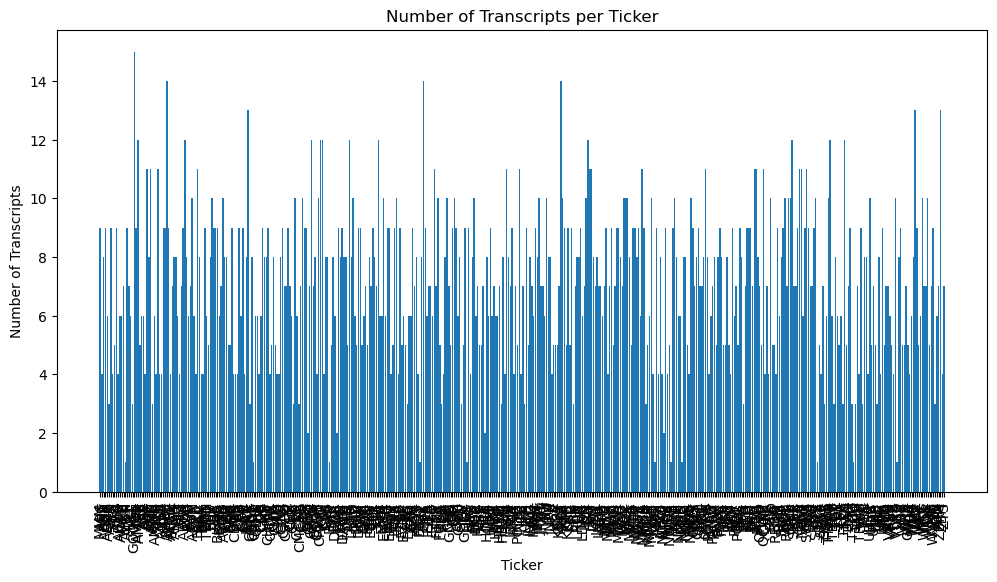

In [155]:
#output_df.to_csv('output_df.csv')
import matplotlib.pyplot as plt

# Plot the number of transcripts per ticker
plt.figure(figsize=(12, 6))
plt.bar(output_df['ticker'], output_df['transcript_count'])
plt.xlabel('Ticker')
plt.ylabel('Number of Transcripts')
plt.title('Number of Transcripts per Ticker')
plt.xticks(rotation=90)
plt.show()

In [156]:
# Remove companies having < 4 earning transcripts
earnings_transcripts = earnings_transcripts.groupby('ticker').filter(lambda x: len(x) >= 4)

### 3. Label the earning transcripts: 
- 1 means the earning transcript has positive impact on stock price: if the price change 1 day after the earning vs 1 day before the earning is >= 2%
- 0 means the earning transcript has neutral impact on stock price: if the price change is > -2% and < 2%
- -1 means the earning transcript has negative impact on stock price: if the price change is <= -2%


In [157]:
earnings_transcripts = earnings_transcripts.rename(columns={'date': 'earning_date'})

In [158]:

# Add D-1 and D+1 columns to earnings_transcripts that correspond to 1 business day before and after E_Date
earnings_transcripts['D-1'] = earnings_transcripts['earning_date'] - pd.offsets.BDay(1)
earnings_transcripts['D+1'] = earnings_transcripts['earning_date'] + pd.offsets.BDay(1)

Find D-1 and D+1 from daily_prices to calculate the price change between 1 day before and after the earning call

In [159]:


# Function to find the closest date in daily_prices to a given date
def find_closest_date(date):
    return daily_prices.index[np.abs(daily_prices.index - date).argmin()]

# Apply the function to find the closest date to D-1 and D+1 for each row in earnings_transcripts
earnings_transcripts['Closest_D-1'] = earnings_transcripts['D-1'].apply(find_closest_date)
earnings_transcripts['Closest_D+1'] = earnings_transcripts['D+1'].apply(find_closest_date)

# Get the prices on the closest dates for D-1 and D+1
earnings_transcripts['Price_bef'] = earnings_transcripts.apply(lambda row: daily_prices.loc[row['Closest_D-1'], ('Adj Close', row['ticker'])], axis=1)
earnings_transcripts['Price_aft'] = earnings_transcripts.apply(lambda row: daily_prices.loc[row['Closest_D+1'], ('Adj Close', row['ticker'])], axis=1)

# Drop the unnecessary columns
earnings_transcripts = earnings_transcripts.drop(['Closest_D-1', 'Closest_D+1'], axis=1)

# Print the updated dataframe
print(earnings_transcripts.head())


          earning_date      exchange        q ticker  \
2  2019-10-23 17:00:00  NASDAQ: LRCX  2020-Q1   LRCX   
11 2021-08-26 09:00:00     NYSE: SJM  2022-Q1    SJM   
19 2019-11-06 16:30:00  NASDAQ: DXCM  2019-Q3   DXCM   
24 2021-07-01 08:30:00   NASDAQ: WBA  2021-Q3    WBA   
25 2021-05-04 08:30:00  NASDAQ: ZBRA  2021-Q1   ZBRA   

                                           transcript                 D-1  \
2   Prepared Remarks:\nOperator\nGood day and welc... 2019-10-22 17:00:00   
11  Prepared Remarks:\nOperator\nGood morning, and... 2021-08-25 09:00:00   
19  Prepared Remarks:\nOperator\nWelcome to the De... 2019-11-05 16:30:00   
24  Prepared Remarks:\nOperator\nLadies and gentle... 2021-06-30 08:30:00   
25  Prepared Remarks:\nOperator\nGood day, and wel... 2021-05-03 08:30:00   

                   D+1   Price_bef   Price_aft  
2  2019-10-24 17:00:00  219.595764  254.317856  
11 2021-08-27 09:00:00  116.974907  113.565285  
19 2019-11-07 16:30:00   38.279999   49.520000  
24 2

In [160]:
# calculate the price change from D-1 to D+1
earnings_transcripts['Price_change'] = earnings_transcripts['Price_aft']/earnings_transcripts['Price_bef'] - 1

Label is 2 when price change >= 2%, 1 when price change between (-2%,2%) and 0 when price change <= -2%

In [185]:
earnings_transcripts['label'] = earnings_transcripts['Price_change'].apply(lambda x: 2 if x >= 0.02 else (0 if x <= -0.02 else 1))

In [211]:
# Count the number of observations for each label
label_counts = earnings_transcripts['label'].value_counts()
print(label_counts)

label
2    1152
1    1123
0     923
Name: count, dtype: int64


In [168]:
# earnings_transcripts.head()


### 5. Convert text data into embeddings

We need to use an embedding technique and then apply ML techniques for classification on the `earnings_transcripts` dataset. For the embedding: we use RoBERTa model (which is improved model from BERT). We then consider 3 techniques: Neural Network, SVM, and Logistic Regression.

1. **Preprocess the Data**: Convert text data into embeddings.
2. **Build the Gated GNN Model**: Define the Neural Network architecture.
3. **Train the Model**: Train the model on the dataset.
4. **Evaluate the Model**: Evaluate the model's performance.
5. **Hyper parameter fine tuning**: Use grid search and Optuna to fine tune hyper parameter and find the best parameter set
6. **Compare the Neural network result with Support Vector Machine and Logistic Regression**


### Convert text to embeddings using RoBERTa

In [212]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from transformers import RobertaTokenizer, RobertaModel




In [32]:
earnings_transcripts.head()

,earning_date,exchange,q,ticker,transcript,D-1,D+1,Price_bef,Price_aft,Price_change,label
2,2019-10-23 17:00:00,NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-22 17:00:00,2019-10-24 17:00:00,219.595779,254.317825,0.158118,1
11,2021-08-26 09:00:00,NYSE: SJM,2022-Q1,SJM,"Prepared Remarks:\nOperator\nGood morning, and...",2021-08-25 09:00:00,2021-08-27 09:00:00,116.974922,113.565269,-0.029149,-1
19,2019-11-06 16:30:00,NASDAQ: DXCM,2019-Q3,DXCM,Prepared Remarks:\nOperator\nWelcome to the De...,2019-11-05 16:30:00,2019-11-07 16:30:00,38.279999,49.520000,0.293626,1
24,2021-07-01 08:30:00,NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,2021-06-30 08:30:00,2021-07-02 08:30:00,44.865547,41.079140,-0.084395,-1
25,2021-05-04 08:30:00,NASDAQ: ZBRA,2021-Q1,ZBRA,"Prepared Remarks:\nOperator\nGood day, and wel...",2021-05-03 08:30:00,2021-05-05 08:30:00,479.049988,482.420013,0.007035,0


In [804]:

# Preprocess the data: convert the text data to embeddingshis step takes 60 minutes. 
# Pls use the cached data in the next cell if you don't want to run this step.
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

earnings_transcripts['embedding'] = earnings_transcripts['transcript'].apply(embed_text)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [806]:
# cache the data to npy file
# np.save('earnings_transcripts_withRoberta.npy', earnings_transcripts)

In [1]:
# Load the data from npy file and follow below step to convert the data to a dataFrame with headers that we can use for training
# earnings_transcripts = np.load('earnings_transcripts_withRoberta.npy',allow_pickle=True)

In [198]:
# earnings_transcripts['label'] = earnings_transcripts['Price_change'].apply(lambda x: 2 if x >= 0.02 else (0 if x <= -0.02 else 1))

In [254]:
# earnings_transcripts=pd.DataFrame(earnings_transcripts)

In [258]:
# earnings_transcripts.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2,2019-10-23 17:00:00,NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,2019-10-22 17:00:00,2019-10-24 17:00:00,219.595779,254.317825,0.158118,2,"[0.019678786, 0.22179195, 0.07228193, 0.012828..."


In [259]:
# earnings_transcripts.columns = ['index', 'earning_date', 'exchange', 'q', 'ticker', 'transcript', 'D-1', 'D+1', 'Price_bef', 'Price_aft', 'Price_change', 'label', 'embedding']

### Split the data into train and test sets

In [260]:
train_start_date = '2019-01-01'
train_end_date = '2021-12-31'
test_start_date = '2022-01-01'
test_end_date = '2023-12-31'

train_data = earnings_transcripts[(earnings_transcripts['earning_date'] >= train_start_date) & (earnings_transcripts['earning_date'] <= train_end_date)]
test_data = earnings_transcripts[(earnings_transcripts['earning_date'] >= test_start_date) & (earnings_transcripts['earning_date'] <= test_end_date)]


In [261]:
#count the number of observations for each label in the training data
train_data['label'].value_counts()

label
1    819
2    759
0    617
Name: count, dtype: int64

In [262]:

#count the number of observations for each label in the training data
test_data['label'].value_counts()

label
2    393
0    306
1    238
Name: count, dtype: int64

In [247]:
#train_data.head()

### Model 1: Feed Forward Neural Network & Hyperparameter tuning with Optuna

In [268]:
# create torch data objects
X_train = torch.tensor(train_data['embedding'].tolist(), dtype=torch.float)
y_train = torch.tensor(train_data['label'].tolist(), dtype=torch.long)
X_test = torch.tensor(test_data['embedding'].tolist(), dtype=torch.float)
y_test = torch.tensor(test_data['label'].tolist(), dtype=torch.long)



In [769]:
# setup model

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import optuna #for hyperparameter tuning

class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [770]:
# Set random seed for reproducibility
import numpy as np
import random

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Set a specific seed for reproducibility

In [773]:
def train_evaluate_model(X_train, y_train, X_test, y_test, hidden_dim, lr, num_epochs, save_path=None):
    input_dim = X_train.shape[1]
    num_classes = len(torch.unique(y_train))
    
    model = FeedForwardNN(input_dim, hidden_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        _, predicted = torch.max(val_outputs, 1)
        accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
        f1 = f1_score(y_test.numpy(), predicted.numpy(), average='weighted')
    if save_path:
        torch.save(model.state_dict(), save_path)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    return f1, accuracy

### Train model with random parameter

In [777]:
# train model with random parameter:
hidden_dim = 512
lr = 1e-4
num_epochs = 100
model = FeedForwardNN(X_train.shape[1], hidden_dim, len(torch.unique(y_train)))
train_evaluate_model(X_train, y_train, X_test, y_test, hidden_dim, lr, num_epochs)

Test Accuracy: 0.3287
Test F1 Score: 0.2560


(0.25602154155762424, 0.3287086446104589)

In [778]:
# plot confusion matrix of the model with random parameter
# Plot the confusion matrix with the best model
import seaborn as sns
def plot_confusion_matrix(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted = torch.max(test_outputs, 1)
        f1 = f1_score(y_test.numpy(), predicted.numpy(), average='weighted')
        cm = confusion_matrix(y_test.numpy(), predicted.numpy())
        labels = ['Negative', 'Neutral', 'Positive']
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()



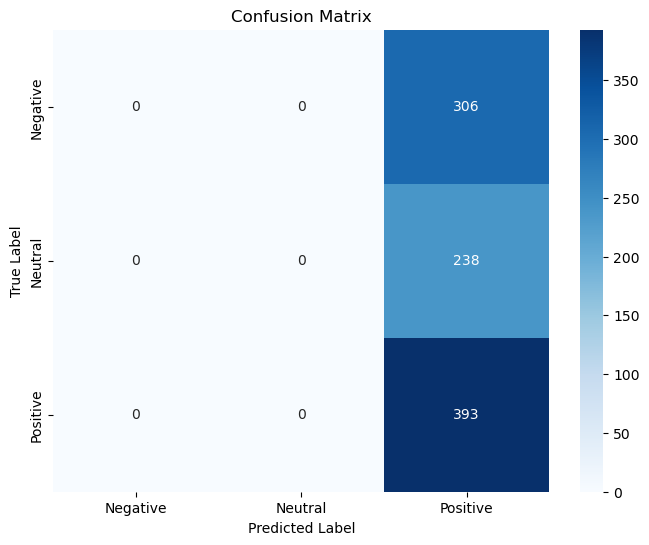

In [779]:
plot_confusion_matrix(model, X_test, y_test)

With the random model: the accuracy is 0.33, the F1 score is 0.33. The model classifies all observations into 'Posivitve'. We will use optuna to tune the hyperparameters of the model.

### Hyper parameter tuning using Optuna library:

In [705]:
# Hyper parameter tuning using Optuna library : find the best parameters for the model to maximize the F1 score
def objective(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256, 512])
    lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    num_epochs = trial.suggest_int('num_epochs', 50, 300)
    
    f1, accuracy = train_evaluate_model(X_train, y_train, X_test, y_test, hidden_dim, lr, num_epochs)
    return f1

# Create and optimize the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

best_trial = study.best_trial
print(f'Best Trial:')
print(f'  Accuracy: {best_trial.value:.4f}')
print(f'  Params:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

best_hidden_dim = best_trial.params['hidden_dim']
best_lr = best_trial.params['learning_rate']
best_num_epochs = best_trial.params['num_epochs']

best_model_path = 'C:/Users/CVUONG12/Downloads/Final project/best_model.pth'
train_evaluate_model(X_train, y_train, X_test, y_test, best_hidden_dim, best_lr, best_num_epochs, save_path=best_model_path)

[I 2024-08-08 12:19:42,175] A new study created in memory with name: no-name-6ee578dd-15a5-45bd-95a1-3d6ea979f95a
C:\Users\CVUONG12\AppData\Local\Temp\ipykernel_23288\1182165316.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-08-08 12:19:43,312] Trial 0 finished with value: 0.3770567077283977 and parameters: {'hidden_dim': 64, 'learning_rate': 0.005283124408414693, 'num_epochs': 238}. Best is trial 0 with value: 0.3770567077283977.
C:\Users\CVUONG12\AppData\Local\Temp\ipykernel_23288\1182165316.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e

Best Trial:
  Accuracy: 0.3842
  Params:
    hidden_dim: 128
    learning_rate: 0.00256106251118606
    num_epochs: 300


(0.37415775389721667, 0.37246531483457845)

In [712]:
# Retrain and save the best model
best_params = best_trial.params
model = FeedForwardNN(input_dim=X_train.shape[1], hidden_dim=best_params['hidden_dim'], num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Retrain with the best parameters
for epoch in range(best_params['num_epochs']):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Save the model
best_model_path = 'C:/Users/CVUONG12/Downloads/Final project/best_model.pth'
torch.save(model.state_dict(), best_model_path)
print(f'Model saved to {best_model_path}')

Model saved to C:/Users/CVUONG12/Downloads/Final project/best_model.pth


### Check the performance of the best model found with Optuna

In [713]:
# Load the best model
model = FeedForwardNN(input_dim=X_train.shape[1], hidden_dim=best_params['hidden_dim'], num_classes=3)
model.load_state_dict(torch.load(best_model_path))

# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
    f1 = f1_score(y_test.numpy(), predicted.numpy(), average='weighted')

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test F1 Score: {f1:.4f}')

Test Accuracy: 0.3810
Test F1 Score: 0.3827


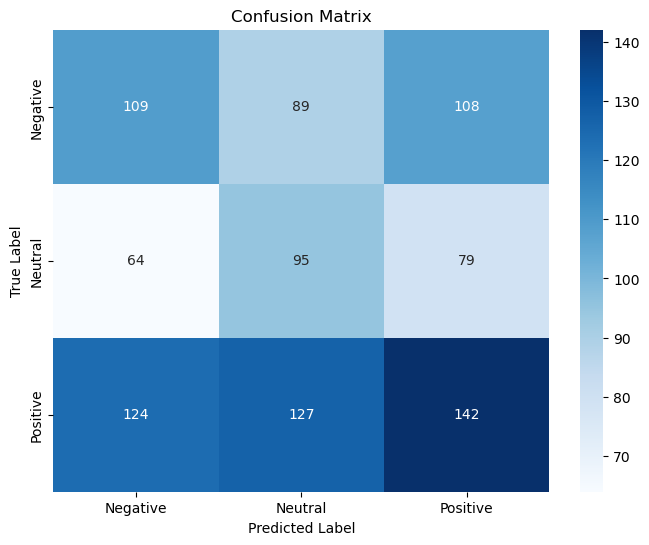

In [711]:
plot_confusion_matrix(model, X_test, y_test)

### Model 2: Gated GNN and model optimisation with dropout

The application of Gated GNN is inspired by the below whitepaper:
https://arxiv.org/pdf/2203.12460#:~:text=This%20means%20that%20earnings%20call,score%20and%20cognitive%20process%20words.

Gated Graph Neural Network (GNN): Combines graph convolutional layers with gating mechanisms (like GRU) to capture both local and sequential dependencies in graph-structured data.

* Input Features: Each node is represented by a 768-dimensional vector, which serves as input features for the model.
* Graph Convolutional Layer (GCNConv): Aggregates information from neighboring nodes to update node features, capturing local graph structure.
* GRU Layer: Introduces a gating mechanism to manage sequential dependencies, improving the model's ability to handle complex graph relationships.
* Fully Connected Layer: Maps the learned hidden representation to output classes (negative, neutral, positive).
* Loss Function: Cross-entropy loss is used to measure prediction errors during training.
* Optimization: Adam optimizer updates the model weights to minimize the loss.

### First, let's set up the model and use Optuna to get the best model, similar to what we did above with FNN

In [715]:
# Below code takes 60 minutes to run. 
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data


# Define the Gated GNN model
class SimpleGatedGNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleGatedGNNClassifier, self).__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        x = x.unsqueeze(1)  # Add sequence dimension for GRU
        gru_input = torch.cat([x, x], dim=1)  # Simple concatenation for GRU input
        gru_output, _ = self.gru(gru_input)
        x = gru_output[:, -1, :]  # Take the last GRU output
        x = self.fc(x)
        return x

def train_evaluate_model(hidden_dim, lr, num_epochs):
    # Initialize the model with suggested hyperparameters
    model = SimpleGatedGNNClassifier(input_dim=768, hidden_dim=hidden_dim, num_classes=3) #768 is the size of the embeddings from RoBERTa
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(train_data.x, train_data.edge_index)
        loss = criterion(outputs, train_data.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_data.x, test_data.edge_index)
        _, predicted = torch.max(test_outputs, 1)
        
        # Convert tensors to numpy arrays for f1 score calculation
        y_true = test_data.y.numpy()
        y_pred = predicted.numpy()
        
        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')
    
    return f1

def objective(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256, 512])
    lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    num_epochs = trial.suggest_int('num_epochs', 50, 300)
    
    f1 = train_evaluate_model(hidden_dim, lr, num_epochs)
    return f1

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Print the best trial information
best_trial = study.best_trial
print(f'Best Trial:')
print(f'  F1 Score: {best_trial.value:.4f}')
print(f'  Params:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# Save the best model
best_model_path = 'C:/Users/CVUONG12/Downloads/Final project/best_gnn_model.pth'
model = SimpleGatedGNNClassifier(input_dim=768, hidden_dim=best_trial.params['hidden_dim'], num_classes=3)
train_evaluate_model(best_trial.params['hidden_dim'], best_trial.params['learning_rate'], best_trial.params['num_epochs'])
torch.save(model.state_dict(), best_model_path)

# Reload the best model and evaluate on test data
model = SimpleGatedGNNClassifier(input_dim=768, hidden_dim=best_trial.params['hidden_dim'], num_classes=3)
model.load_state_dict(torch.load(best_model_path))

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_outputs = model(test_data.x, test_data.edge_index)
    _, predicted = torch.max(test_outputs, 1)
    
    # Convert tensors to numpy arrays for f1 score calculation
    y_true = test_data.y.numpy()
    y_pred = predicted.numpy()
    
    # Calculate F1 score
    final_f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'Final F1 Score on Test Data: {final_f1:.4f}')

[I 2024-08-08 12:44:37,102] A new study created in memory with name: no-name-f94ec3ff-b96b-4f14-9cf0-85caa2dba266
C:\Users\CVUONG12\AppData\Local\Temp\ipykernel_23288\1258062455.py:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-08-08 12:44:44,261] Trial 0 finished with value: 0.2770241443209178 and parameters: {'hidden_dim': 64, 'learning_rate': 0.0018307557412962031, 'num_epochs': 188}. Best is trial 0 with value: 0.2770241443209178.
C:\Users\CVUONG12\AppData\Local\Temp\ipykernel_23288\1258062455.py:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-4,

Best Trial:
  F1 Score: 0.3820
  Params:
    hidden_dim: 64
    learning_rate: 0.005545181338567817
    num_epochs: 54
Final F1 Score on Test Data: 0.1360


### Evaluate the performance of the optimized model found with Optuna

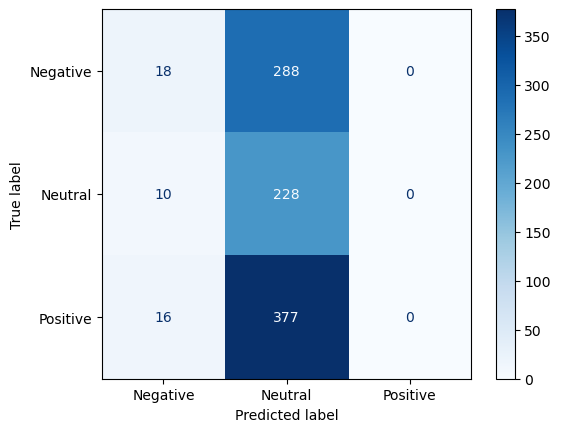

In [737]:
# Evaluate on test data and plot confusion matrix
model.eval()
with torch.no_grad():
    test_outputs = model(test_data.x, test_data.edge_index)
    _, predicted = torch.max(test_outputs, 1)
    
    # Convert tensors to numpy arrays for confusion matrix calculation
    y_true = test_data.y.numpy()
    y_pred = predicted.numpy()
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Negative', 'Neutral', 'Positive'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

The above result after using Optuna to tune the hyper parameter shows that the model might be overfitted, as it had good F1 score on train data (38.2) but poor score on the test data (13.6). We will introduce dropout to reduce the overfitting. 

### Use dropout to reduce overfitting

In [765]:
# Define the Gated GNN model with dropout for regularization
class SimpleGatedGNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout_rate=0.5):
        super(SimpleGatedGNNClassifier, self).__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        x = x.unsqueeze(1)  # Add sequence dimension for GRU
        gru_input = torch.cat([x, x], dim=1)  # Simple concatenation for GRU input
        gru_output, _ = self.gru(gru_input)
        x = gru_output[:, -1, :]  # Take the last GRU output
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Initialize and train the model
def train_model(model, train_data, y_train, num_epochs=300, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_data.x, train_data.edge_index)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



set_seed(42)  # Set a specific seed for reproducibility
# Create and train the best model
gnn_dropout = SimpleGatedGNNClassifier(input_dim=768, hidden_dim=256, num_classes=3, dropout_rate=0.5)
train_model(gnn_dropout, train_data, y_train)



c:\Users\CVUONG12\AppData\Local\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### Performance of the model with dropout

Final F1 Score on Test Data: 0.3698
Accuracy: 0.3757


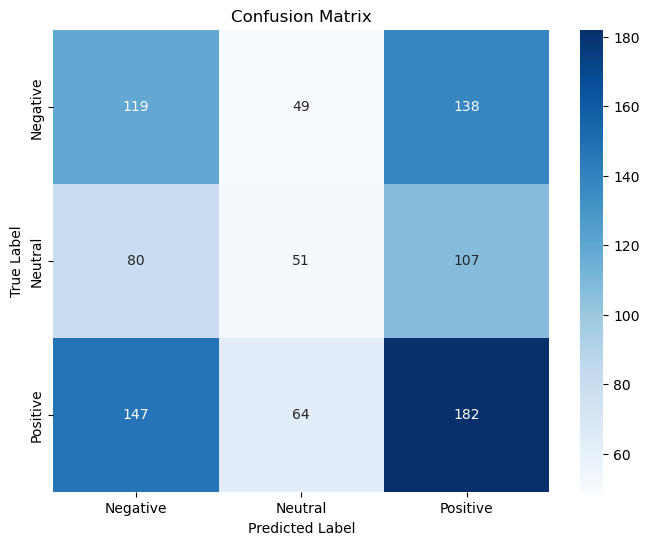

In [766]:

# Plot the confusion matrix with the model with dropout and F1 score
gnn_dropout.eval()
with torch.no_grad():
    test_outputs = gnn_dropout(test_data.x, test_data.edge_index)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    final_f1 = f1_score(y_test, predicted, average='weighted')
    print(f'Final F1 Score on Test Data: {final_f1:.4f}')
    
    print(f'Accuracy: {accuracy:.4f}')
    cm = confusion_matrix(y_test.numpy(), predicted.numpy())
    labels = ['Negative', 'Neutral', 'Positive']
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Conclusion: we can see that adding drop out improve clearly the performance of the model on test data. The model can now classify the earning transcript into 3 classes: Negative, Neutral, Positive with F1 score of 0.369. The model can be further improved by tuning the hyperparameters or using more complex model.

### Model 3: Support Vector Machine (SVM) Classifier and Fine tuning using gried search CV

In [786]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.stats import loguniform

# Train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_f1 = f1_score(y_test, svm_predictions, average='weighted')
print(f'SVM F1 score: {svm_f1:.4f}')

SVM F1 score: 0.3572


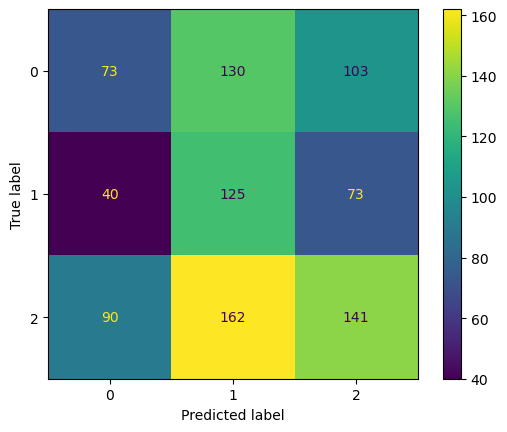

In [792]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC

# Compute the confusion matrix
def plot_confusion(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    # Show the plot
    plt.show()

# Plot the confusion matrix for the SVM model
plot_confusion(svm_model, X_test, y_test)

### Fine tuning SVM using grid search

In [790]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.stats import loguniform

# Fine-Tuning SVM for F1 Score
svm_param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

svm = SVC()

svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid, cv=5, scoring='f1_weighted')
svm_grid_search.fit(X_train, y_train)

best_svm_params = svm_grid_search.best_params_
best_svm_f1_score = svm_grid_search.best_score_

print(f'Best SVM Parameters: {best_svm_params}')
print(f'Best SVM F1 Score (Train): {best_svm_f1_score:.4f}')

# Test the best SVM model on the test data
svm_best_model = svm_grid_search.best_estimator_
svm_test_predictions = svm_best_model.predict(X_test)
svm_test_f1_score = f1_score(y_test, svm_test_predictions, average='weighted')
print(f'SVM F1 Score (Test): {svm_test_f1_score:.4f}')


Best SVM Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM F1 Score (Train): 0.3784
SVM F1 Score (Test): 0.3658


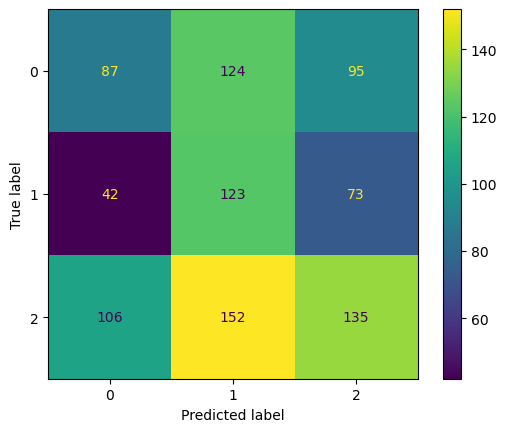

In [793]:
plot_confusion(svm_best_model, X_test, y_test)

### Model 4: Logistic Regression & Fine tuning using random search 

In [795]:
# Train Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_f1 = f1_score(y_test, log_reg_predictions, average='weighted')
print(f'Logistic Regression F1 score: {log_reg_f1:.4f}')

Logistic Regression F1 score: 0.3709


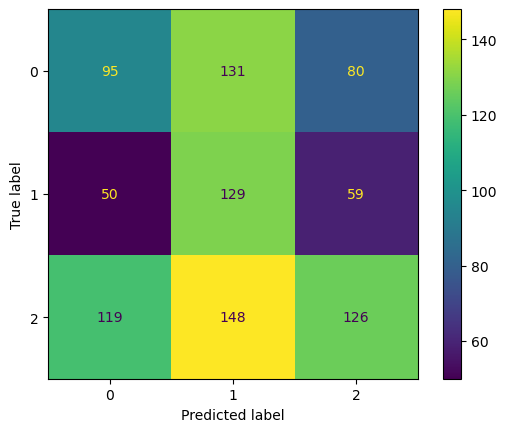

In [796]:
plot_confusion(log_reg_model, X_test, y_test)